Author: Rustom Ichhaporia - rustomi2@illinois.edu

AI-Powered Lifecycle Financial Planning Exercise

Before beginning, we'll import the relevant libraries. 

In [117]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from statistics import mean,median,mode
from statsmodels.graphics.api import abline_plot
from statsmodels.tools.eval_measures import rmse
from patsy import dmatrices

The first step will be to read in and display the test dataframe. 


In [118]:
df = pd.read_csv('data/test_dataset.csv')
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


Because `CustomerID` matches the default indices with a difference of only 1, we'll use it as our index column. 

In [119]:
df = df.set_index('CustomerID')

Next, we'll rename the columns to remove spaces and parentheses to make it easier to use the titles. We'll also encode the categorical gender column in binary so we are only dealing with numerical data.  

In [120]:
df = df.rename(columns={'Annual Income (k$)': 'Income', 'Spending Score (1-100)': 'Spending_Score'})
df = df.replace(['Male', 'Female'], [0, 1])

Now, we'll print the descriptive statistics for the data. `Gender` is roughly equally split, with an average `Age` of 38 and `Spending_Score` of 50. 

In [121]:
df.describe()

,Gender,Age,Income,Spending_Score
count,200.000000,200.000000,200.000000,200.000000
mean,0.560000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,28.750000,41.500000,34.750000
50%,1.000000,36.000000,61.500000,50.000000
75%,1.000000,49.000000,78.000000,73.000000
max,1.000000,70.000000,137.000000,99.000000


To get a sense for the distribution of these variables, we will print histograms for the effectively continuous variables. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9403e25460>,
      dtype=object)

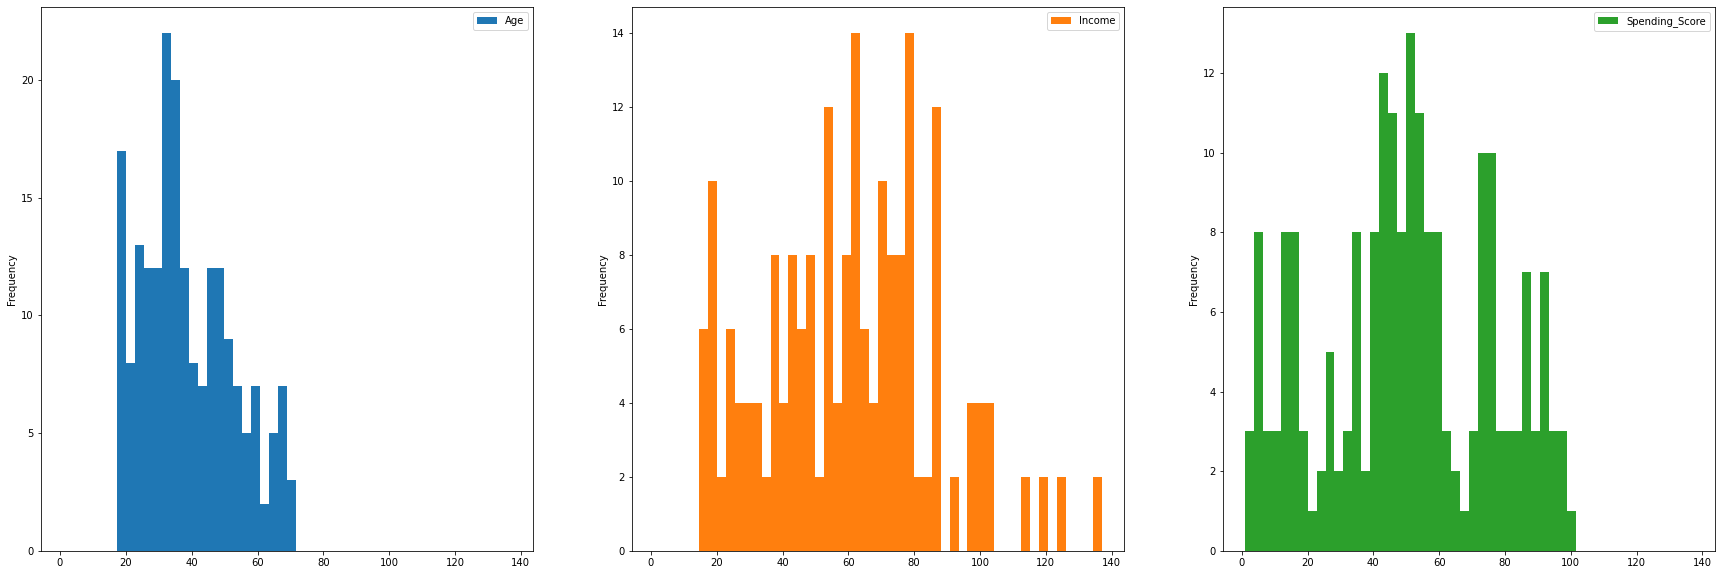

In [122]:
df[['Age', 'Income', 'Spending_Score']].plot.hist(bins=50, subplots=True, layout=(1, 3), figsize=(30, 10))

The shape of the `Spending_Score` seems to be trimodal, while `Age` is slightly skewed right. To investigate further, we will print scatterplots for the same variables. 

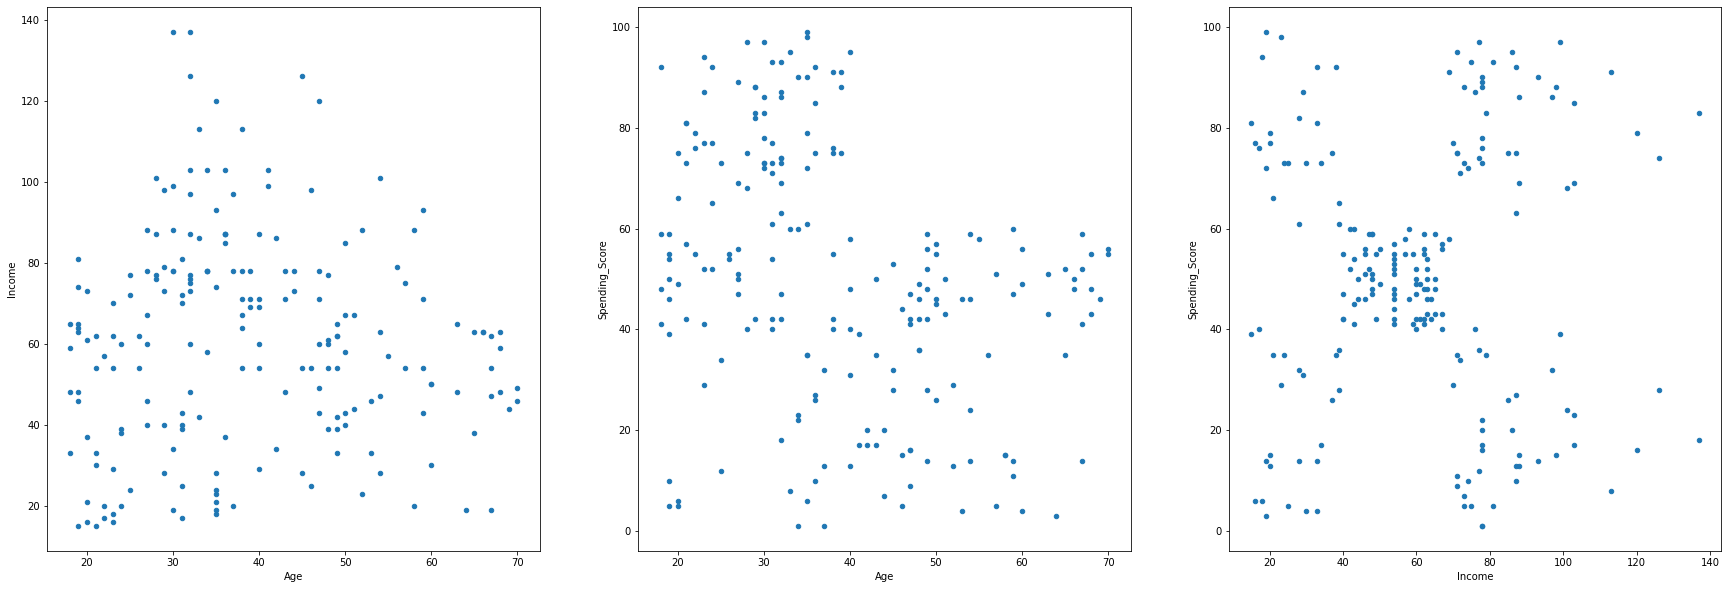

In [123]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

df.plot.scatter(x='Age', y='Income', ax=axes[0])
df.plot.scatter(x='Age', y='Spending_Score', ax=axes[1])
df.plot.scatter(x='Income', y='Spending_Score', ax=axes[2])


We are now ready to make a generalized linear model (`GLM`) to fit the data. The first step to creating this is to split the data into target and predictor variables for model training. 

In [124]:
y, X = dmatrices('Spending_Score ~ Gender + Age + Income', data=df, return_type='dataframe')

We will create a `GLM` model with default distribution family, Gaussian. Then, we will fit the model to the data and prints the results. 

In [125]:
model = sm.GLM(y, X)

In [126]:
result = model.fit()
print(result.summary())

Generalized Linear Model Regression Results                  
Dep. Variable:         Spending_Score   No. Observations:                  200
Model:                            GLM   Df Residuals:                      196
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          603.53
Method:                          IRLS   Log-Likelihood:                -922.05
Date:                Sat, 22 Aug 2020   Deviance:                   1.1829e+05
Time:                        23:39:26   Pearson chi2:                 1.18e+05
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     71.9168      7.023     10.240      0.000      58.152   

It seems that the p-value of the `Gender` (0.566) and `Income` (0.905) variables is very high, while the p-value of the `Age` variable is close to zero. Because the former two variables seem to be extraneous to the model, we can remove them and remake the model. Before that, let's look at the plots of the initial model as it was fitted to the data. 

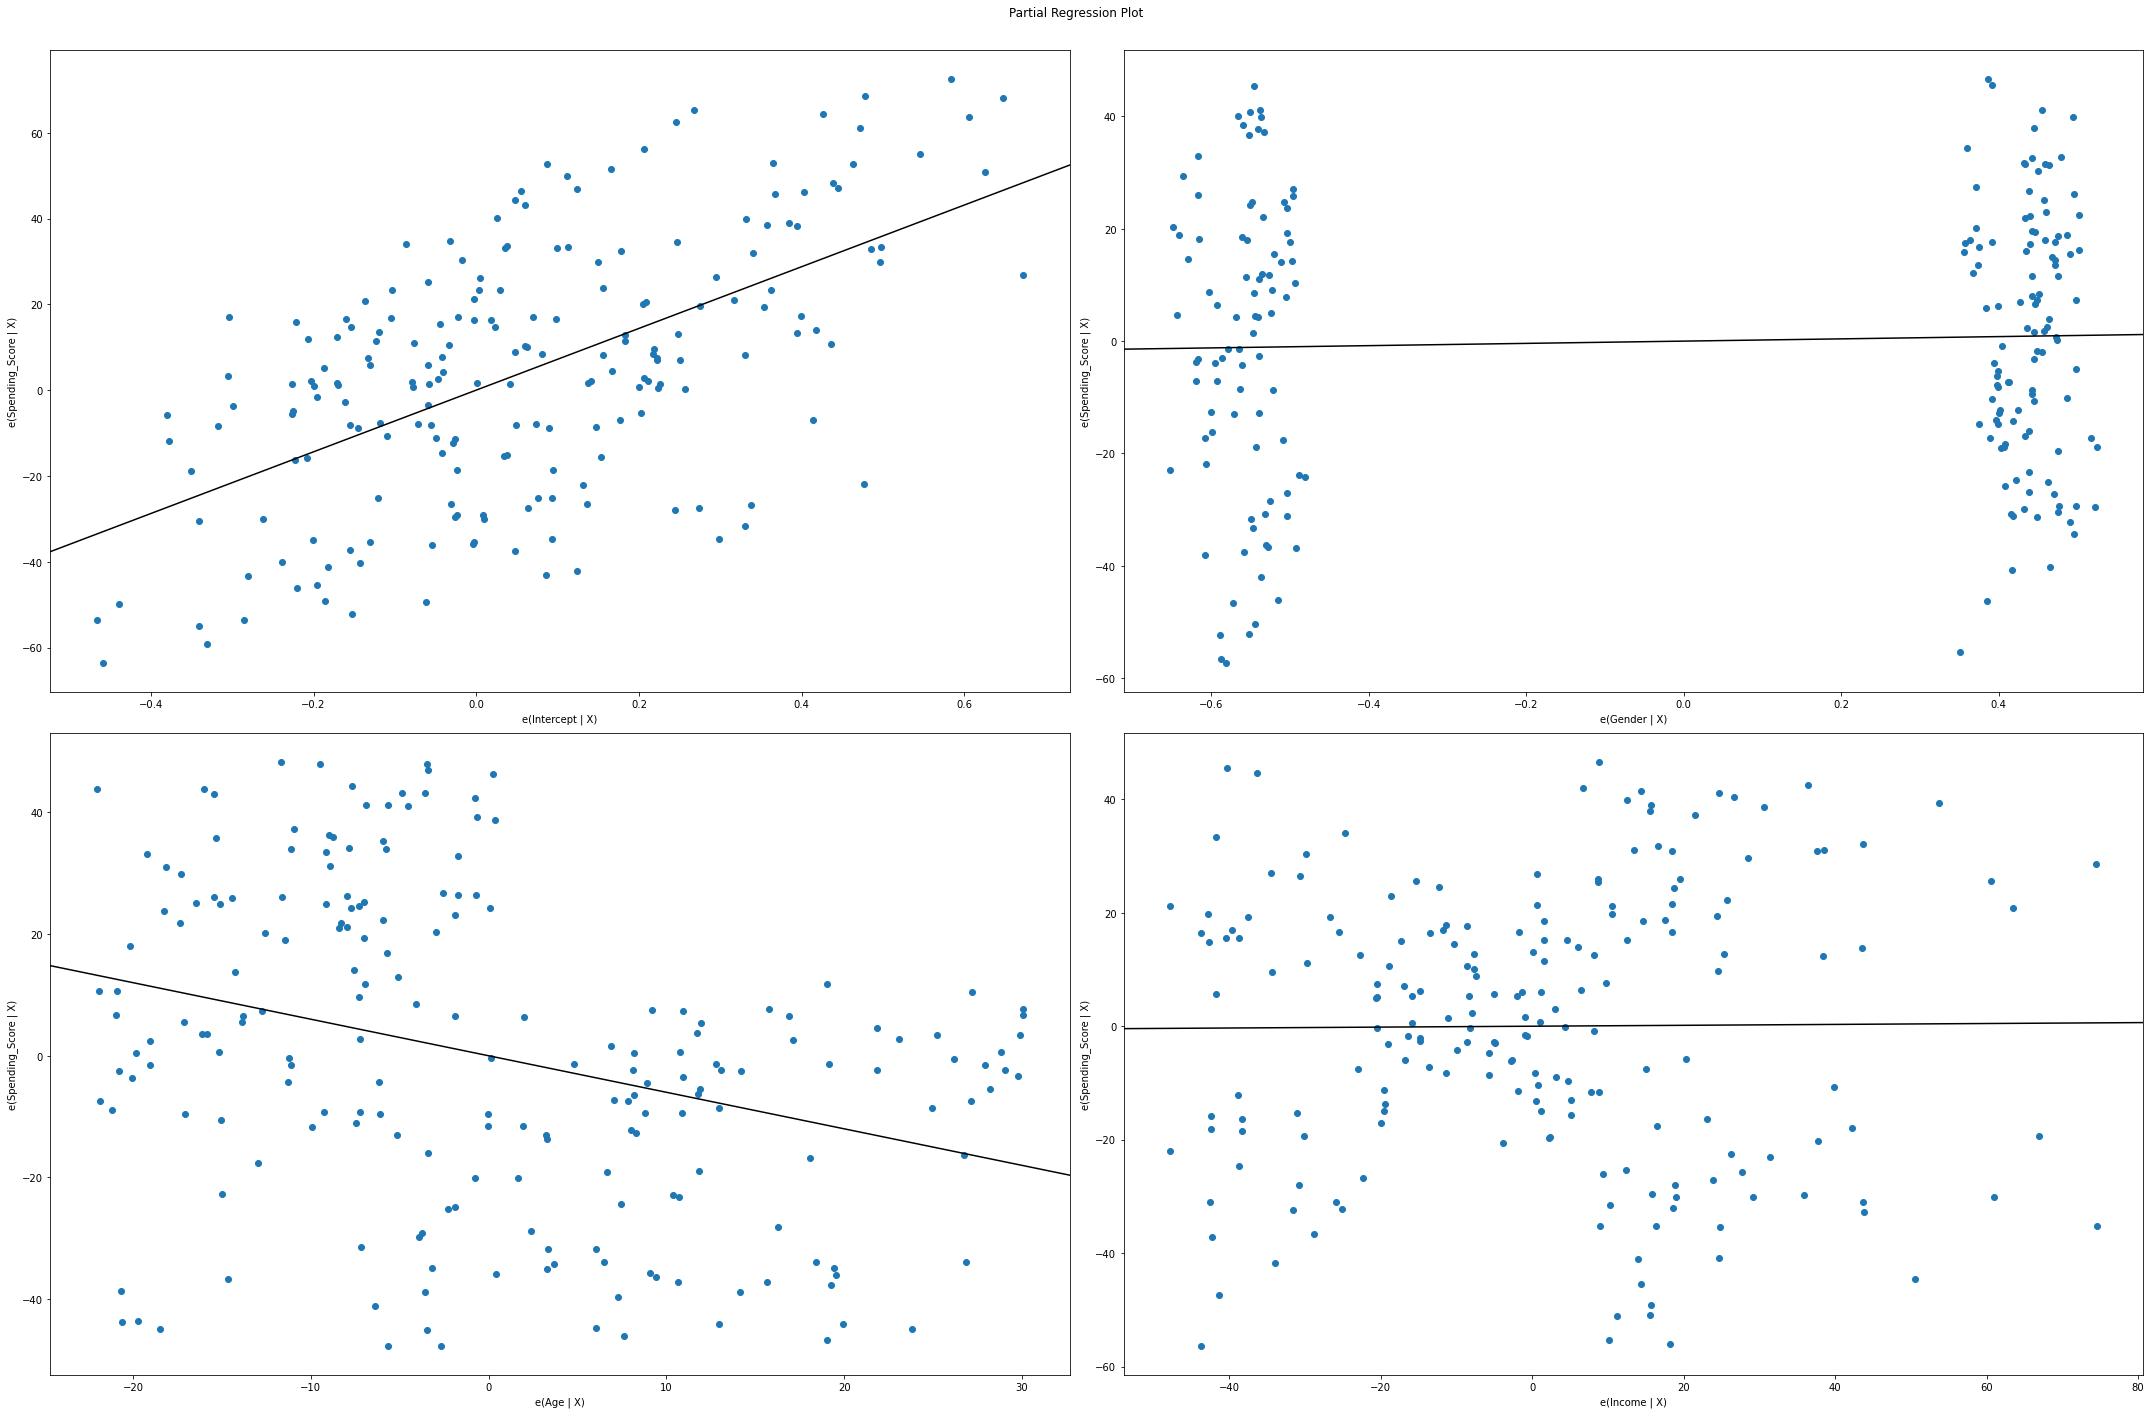

In [127]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(30,20))
    fig = sm.graphics.plot_partregress_grid(result)

The correlation of the spending score with the intercept constant and `Age` is strong, but the correlation with gender is weak at best. `Spending_Score` exhibits a very odd distribution of variance, with high variance at values of `Income` below 40 and above 60, but very low variance between those two values. This suggests a plain linear model through `Income` may not be the best fit. Because the data is both continuous and non-negative, the Gamma family with identity link function is a good choice. The model might be better if created as a robust linear model due to the aforementioned nonuniform variance, but the prompt requests a generalized linear model. An interaction term between `Age` and `Income` can also be added. 

/Users/rustomichhaporia/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:274: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn(("The %s link function does not respect the domain "
                 Generalized Linear Model Regression Results                  
Dep. Variable:         Spending_Score   No. Observations:                  200
Model:                            GLM   Df Residuals:                      193
Model Family:                   Gamma   Df Model:                            6
Link Function:               identity   Scale:                         0.24731
Method:                          IRLS   Log-Likelihood:                -958.86
Date:                Sat, 22 Aug 2020   Deviance:                       85.715
Time:                        23:39:27   Pearson chi2:                     47.7
No. Iterations:                   100                                         
Covariance 

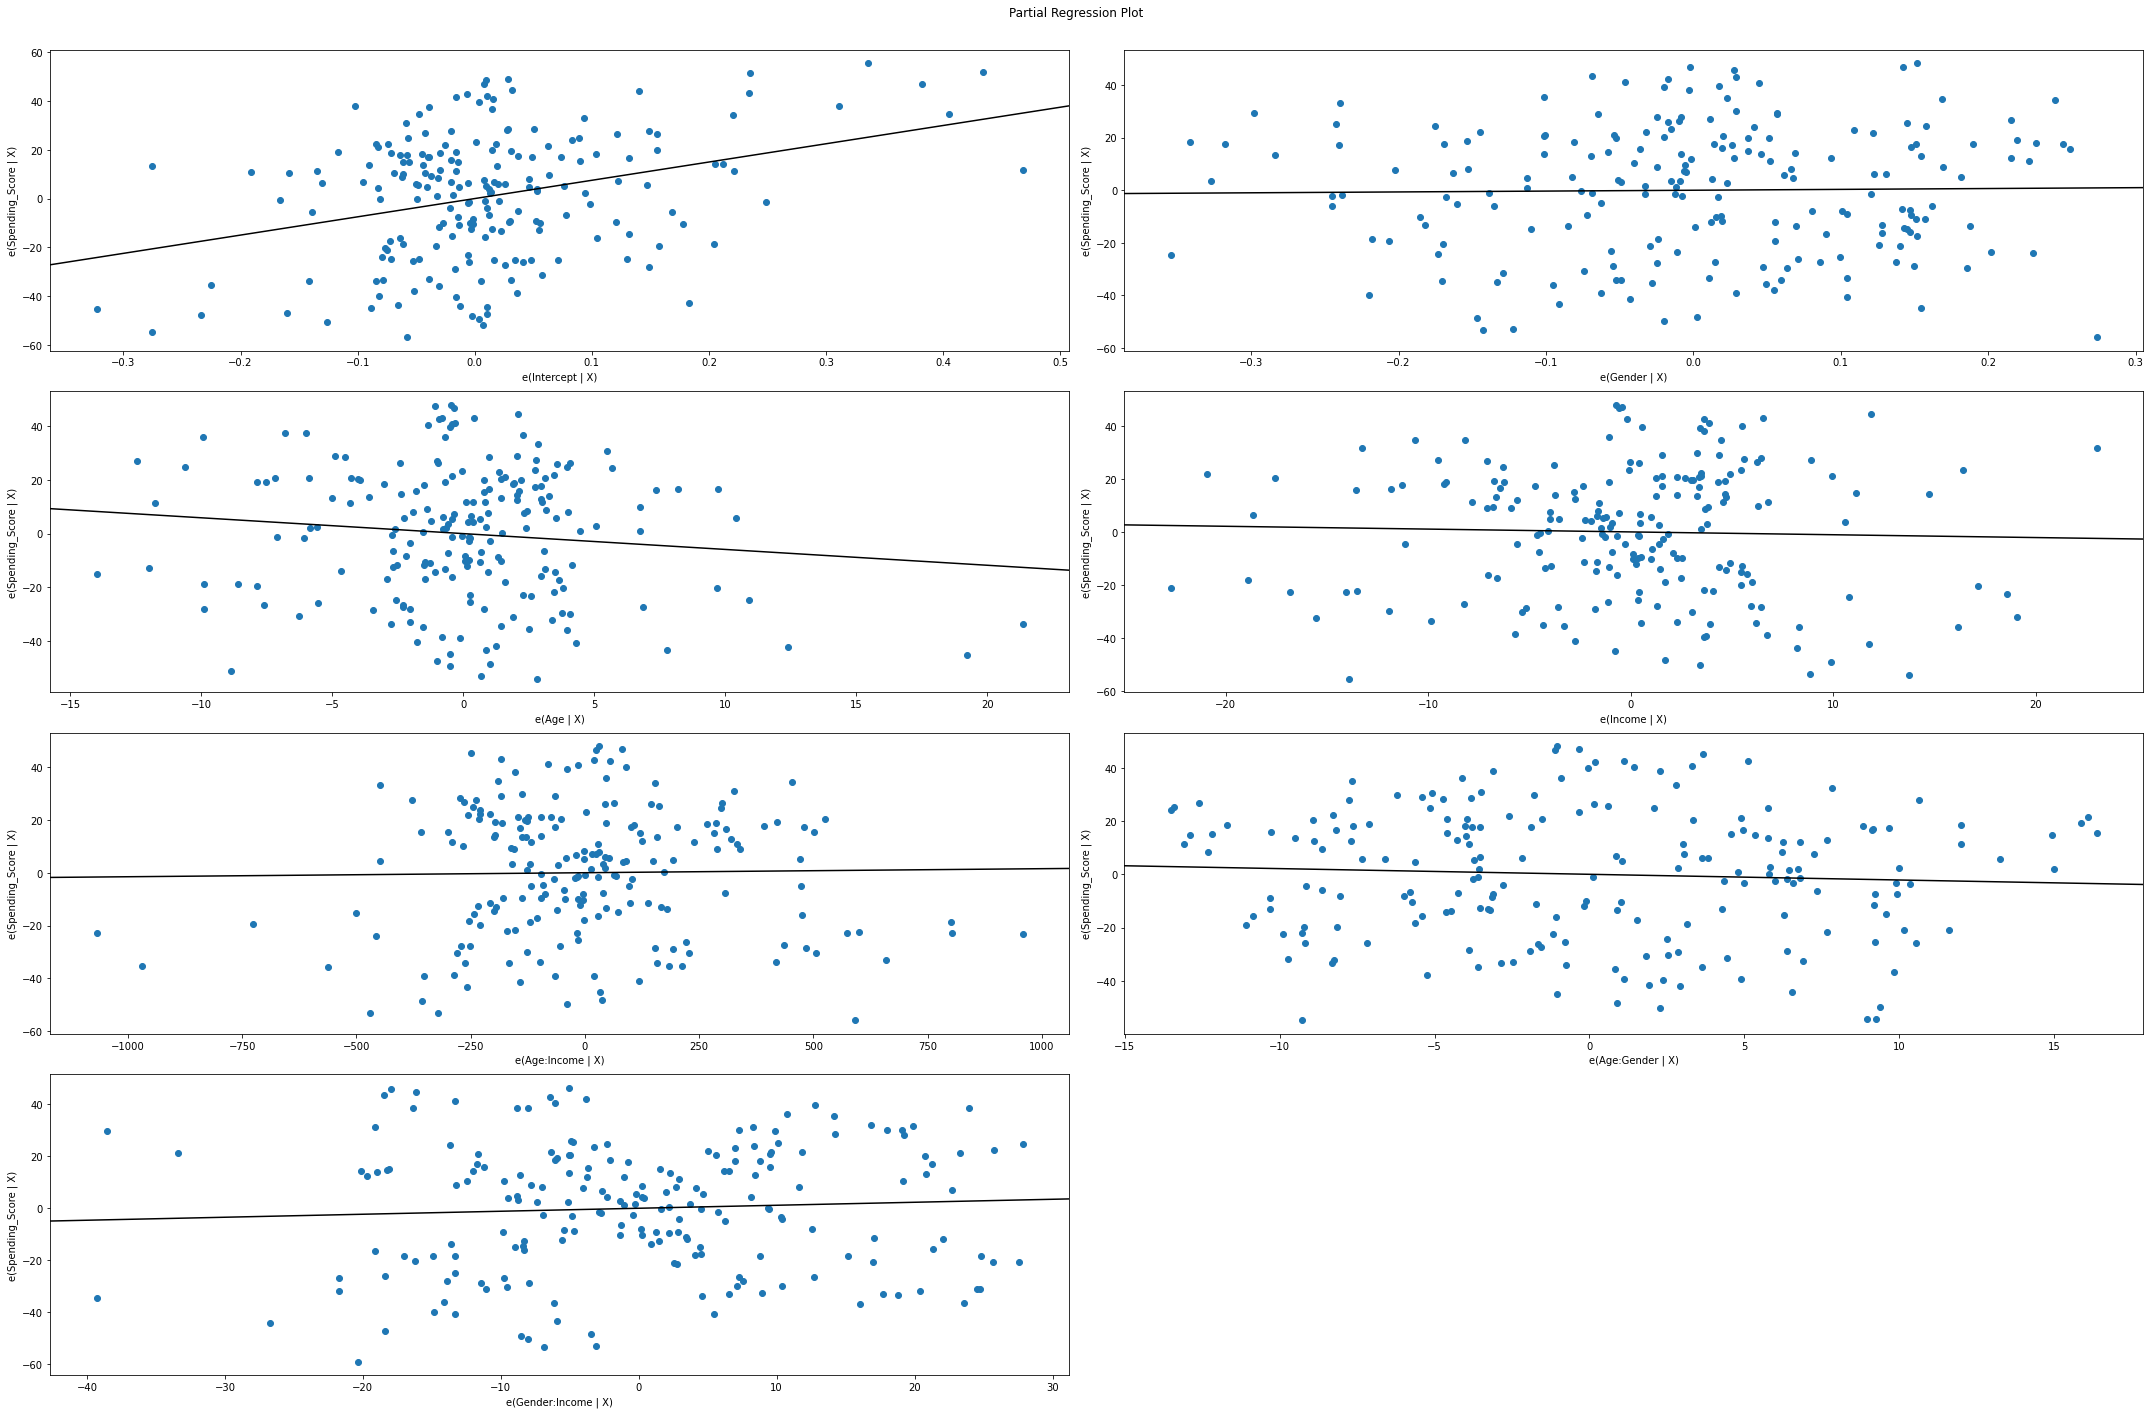

In [128]:
y, X = dmatrices('Spending_Score ~ Gender + Age + Income + Age*Income + Age*Gender + Gender*Income', data=df, return_type='dataframe')
model2 = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.identity))
result2 = model2.fit()
print(result2.summary())
with mpl.rc_context():
    mpl.rc("figure", figsize=(30,20))
    fig = sm.graphics.plot_partregress_grid(result2)

We see that the `Gender`, `Age*Gender`, and `Gender*Income` terms are not statistically significant, so they can be dropped, but `Age`, `Income`, and `Age*Income` are statistically significant. Now, we will attempt 10-fold cross validation to test the model. 

/Users/rustomichhaporia/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:274: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn(("The %s link function does not respect the domain "
                 Generalized Linear Model Regression Results                  
Dep. Variable:         Spending_Score   No. Observations:                  200
Model:                            GLM   Df Residuals:                      196
Model Family:                   Gamma   Df Model:                            3
Link Function:               identity   Scale:                         0.24159
Method:                          IRLS   Log-Likelihood:                -960.88
Date:                Sat, 22 Aug 2020   Deviance:                       85.884
Time:                        23:39:28   Pearson chi2:                     47.4
No. Iterations:                   100                                         
Covariance 

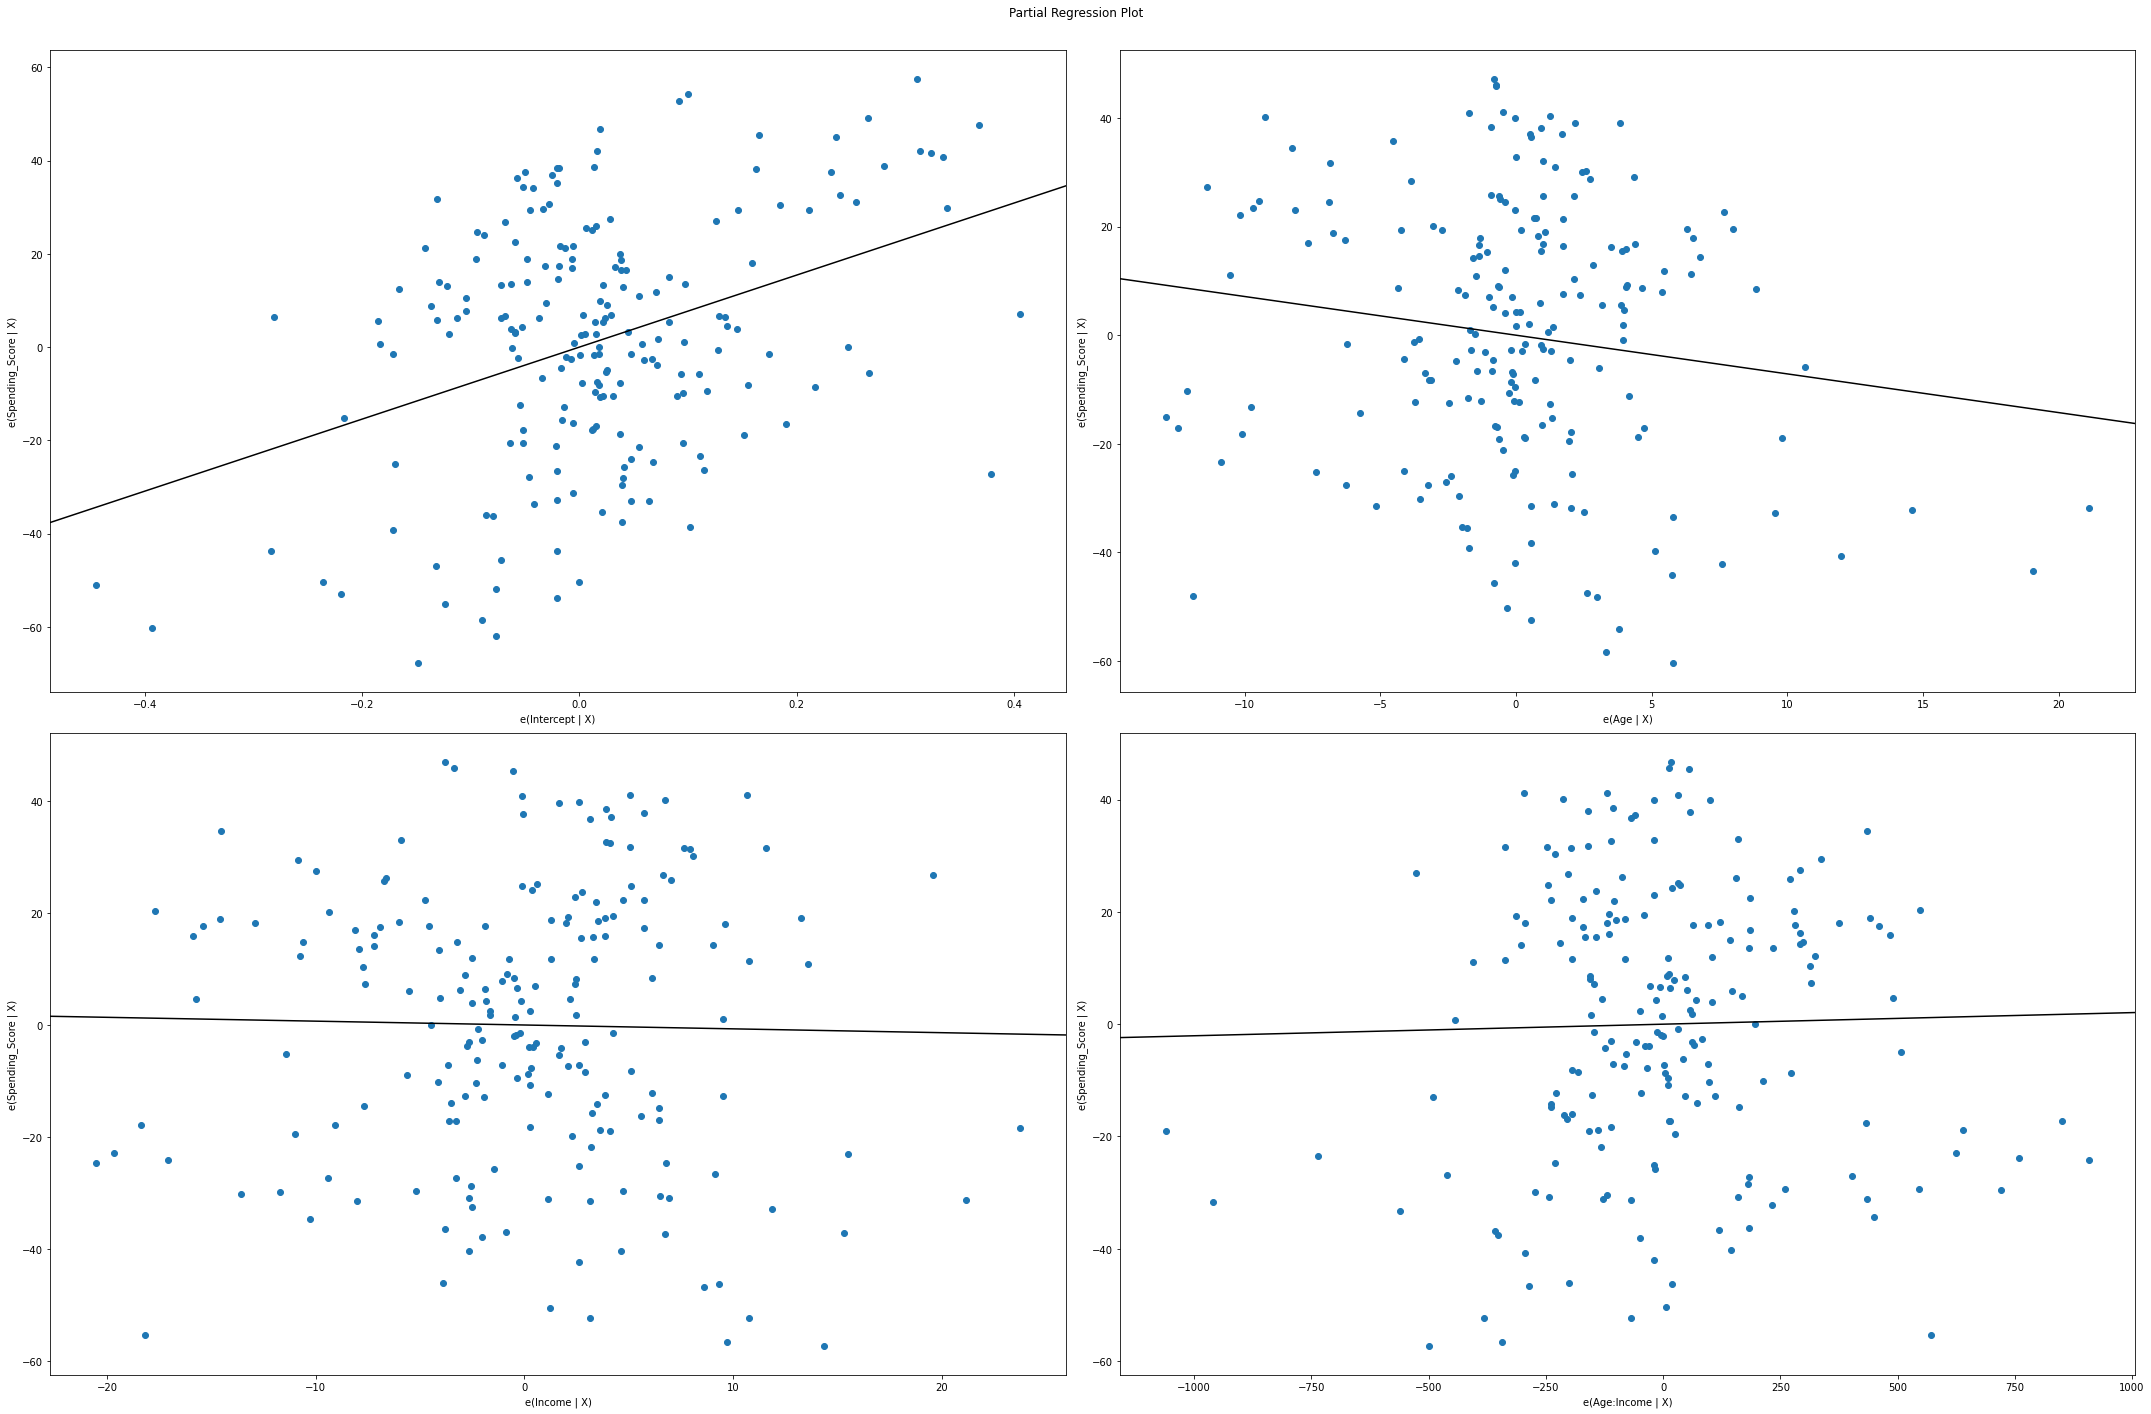

In [129]:
y, X = dmatrices('Spending_Score ~ Age + Income + Age*Income', data=df, return_type='dataframe')
model3 = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.identity))
result3 = model3.fit()
print(result3.summary())
with mpl.rc_context():
    mpl.rc("figure", figsize=(30,20))
    fig = sm.graphics.plot_partregress_grid(result3)

In [136]:
def create_folds(n_folds, index): 
    test_fold = df[(index*n_folds):(index*n_folds)+(len(df) / n_folds)]
    train_fold = df[~df.isin(test_fold)].dropna()
    return test_fold, train_fold

In [ ]:
rmse = []
y, X = dmatrices('Spending_Score ~ Gender + Age + Income + Age*Income + Age*Gender + Gender*Income', data=df, return_type='dataframe')
for i in range(10):
    test, train = create_folds(10, i)
    model = sm.GLM(test, train)
    rmse.append(rmse(model.predict(train), test))

In [ ]:
rmse2 = []
y, X = dmatrices('Spending_Score ~ Gender + Age + Income + Age*Income + Age*Gender + Gender*Income', data=df, return_type='dataframe')
for i in range(10):
    test, train = create_folds(20, i)
    model2 = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.identity))
    rmse2.append(rmse(model2.predict(train), test))

In [ ]:
rmse3 = []
y, X = dmatrices('Spending_Score ~ Age + Income + Age*Income', data=df, return_type='dataframe')
for i in range(10):
    test, train = create_folds(20, i)
    model3 = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.identity))
    rmse3.append(model3.predict(train), test))

In [ ]:
print(mean(rmse))
print(mean(rmse2))
print(mean(rmse3))

The 10-fold cross validation is incomplete due to time constraints, but the resulting root mean squared errors would differentiate the models. 